In [109]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [110]:
L = 1.
NX = NY = 64
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L
TOL = 1e-3

In [111]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [112]:
dx = x[1] - x[0]
dy = y[1] - y[0]

In [113]:
u = lambda x, y: (x**2 - 1.)*(y**2 - 1.)
f = lambda x, y: -2.*(2. - x**2 - y**2)

In [114]:
U = u(X, Y)
F = f(X, Y)

In [115]:
U_ravel = jnp.ravel(U)
F_ravel = jnp.ravel(F)
size_of_row = NX+1
index_arr = jnp.ravel(jnp.arange((NX + 1)*(NX + 1)).reshape((NX+1, NX+1)))
index_arr_int = jnp.ravel((jnp.arange((NX + 1)*(NX + 1)).reshape((NX+1, NX+1))[1:-1, 1:-1]))
u_size = size_of_row**2

In [116]:
def node_select(index, u, func, row_size=size_of_row):
    cond1 = jnp.squeeze(jnp.mod(index, row_size) == 0)
    cond2 = jnp.any(jnp.isin(index, (row_size - 1) + (row_size)*jnp.arange(1,row_size)), keepdims=False)
    return jax.lax.cond(cond1 | cond2, lambda index, u: u[index], func, index, u)

def node_compute(index, u, f=F_ravel, row_size=NX+1, dx=dx, dy=dy):
    u_ijm1, u_ij, u_ijp1, u_im1j, u_ip1j = jnp.hstack((jax.lax.dynamic_slice_in_dim(u, index - 1, 3), jax.lax.dynamic_index_in_dim(u, index - row_size), jax.lax.dynamic_index_in_dim(u, index + row_size)))
    return jnp.squeeze(jax.lax.dynamic_index_in_dim(f, index) - ((u_ijp1 - 2*u_ij + u_ijm1)/dx**2) - ((u_ip1j - 2*u_ij + u_im1j)/dy**2))

In [117]:
u_init = U_ravel.at[index_arr_int].set(0)
r_init = jnp.zeros((NX+1)*(NX+1))
r_init = r_init.at[index_arr_int].set(jax.vmap(node_select, in_axes=(0, None, None))(index_arr_int, u_init, node_compute))
p_init = r_init.clone()
urp_init = jnp.vstack((u_init, r_init, p_init))

In [118]:
@jax.jit
def q_compute(index, p, row_size=size_of_row, dx=dx, dy=dy):
    p_ijm1, p_ij, p_ijp1, p_im1j, p_ip1j = jnp.hstack((jax.lax.dynamic_slice_in_dim(p, index - 1, 3), jax.lax.dynamic_index_in_dim(p, index - row_size), jax.lax.dynamic_index_in_dim(p, index + row_size)))
    return  (p_ijp1 - 2*p_ij + p_ijm1)/dx**2 + (p_ip1j - 2*p_ij + p_im1j)/dy**2

@jax.jit
def cg_main_loop(urp, index_arr=index_arr_int):
    u, r, p = urp
    
    q = jnp.zeros_like(u)
    q = q.at[index_arr].set(jax.vmap(q_compute, in_axes=(0, None))(index_arr, p))
    rho = jnp.matmul(r, r)
    alpha = rho/jnp.matmul(p,q)
    
    u = u.at[index_arr].set(u[index_arr] + alpha * p[index_arr])
    r = r.at[index_arr].set(r[index_arr] - alpha * q[index_arr])
    
    rho_new = jnp.matmul(r, r)
    beta = rho_new/rho
    p = p.at[index_arr].set(r[index_arr] + beta * p[index_arr])
    
    return jnp.vstack((u,r,p))

def tol_check(urp, U_ravel=U_ravel, TOL=TOL, u_size=u_size):
    u, a, b = urp
    return jnp.sum(jnp.absolute(u - U_ravel))/u_size > TOL

In [119]:
u_num = jax.lax.while_loop(tol_check, cg_main_loop, urp_init)

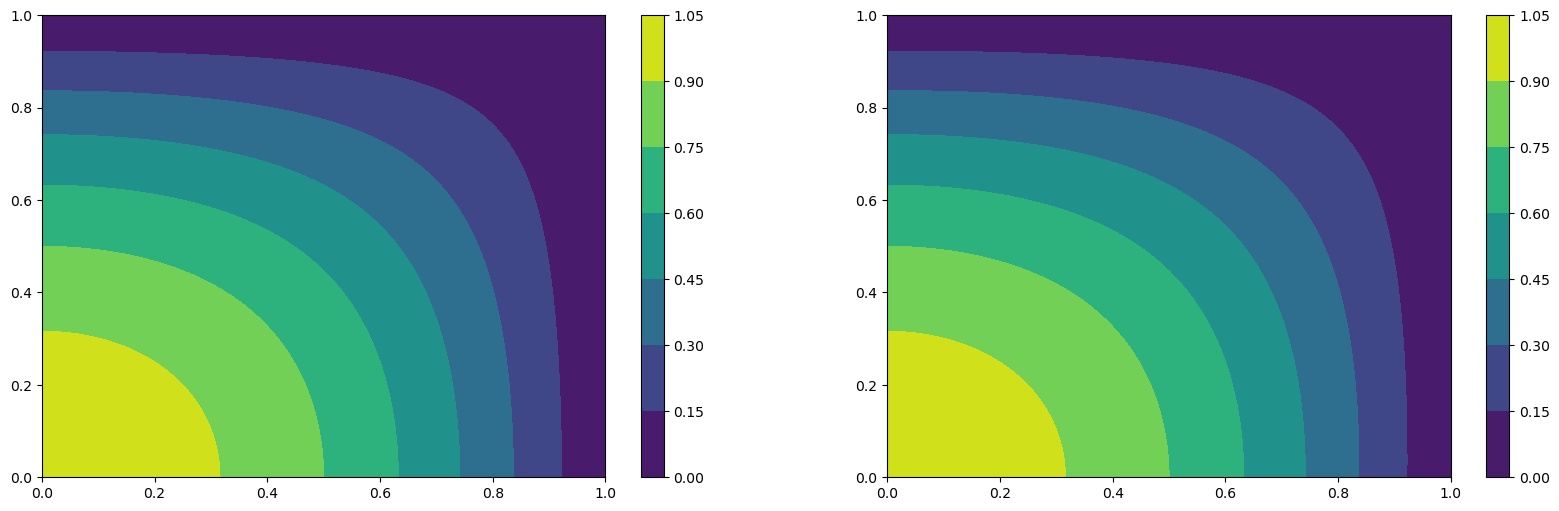

In [120]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
true = axs[0].contourf(X, Y, U)
num = axs[1].contourf(X, Y, u_num[0].reshape(NX+1,NX+1))

fig.colorbar(true)
fig.colorbar(num)
plt.show()
